# Machine Learning -  Multi-class Classification with Imbalanced Data-set

In [1]:
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer # Changed import statement
from tensorflow.keras.models import Sequential, Model # Changed import statement
from tensorflow.keras.layers import Activation, Dense, Dropout # Changed import statement
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
# For reproducibility
np.random.seed(1237)

In [2]:
!wget https://raw.githubusercontent.com/dasarpai/DAI-Datasets/main/20news-bydate-dataset.zip
!mkdir tempdata
!unzip -q 20news-bydate-dataset.zip -d tempdata

--2024-11-12 12:42:05--  https://raw.githubusercontent.com/dasarpai/DAI-Datasets/main/20news-bydate-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22726291 (22M) [application/zip]
Saving to: ‘20news-bydate-dataset.zip’

20news-bydate-datas 100%[===================>]  21.67M   120MB/s    in 0.2s    

2024-11-12 12:42:06 (120 MB/s) - ‘20news-bydate-dataset.zip’ saved [22726291/22726291]



In [3]:
# Source file directory
# downlaod from http://qwone.com/~jason/20Newsgroups/

path_train = "tempdata/20news-bydate-train"

files_train = skds.load_files(path_train,load_content=False)

label_index = files_train.target
label_names = files_train.target_names
labelled_files = files_train.filenames

In [4]:
label_index

array([ 9,  4, 11, ..., 16, 18,  4])

In [5]:
label_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
labelled_files

array(['tempdata/20news-bydate-train/rec.sport.baseball/102736',
       'tempdata/20news-bydate-train/comp.sys.mac.hardware/50485',
       'tempdata/20news-bydate-train/sci.crypt/15246', ...,
       'tempdata/20news-bydate-train/talk.politics.guns/54663',
       'tempdata/20news-bydate-train/talk.politics.misc/178534',
       'tempdata/20news-bydate-train/comp.sys.mac.hardware/51858'],
      dtype='<U59')

In [7]:
data_tags = ["filename","category","news"]
data_list = []

# Read and add data from file to a list
i=0
for f in labelled_files:
    # Specify the encoding as 'latin-1' to handle the problematic byte sequence
    # If 'latin-1' doesn't work, try 'ISO-8859-1' or other encodings
    data_list.append((f,label_names[label_index[i]],Path(f).read_text(encoding='latin-1', errors='ignore')))
    i += 1

# We have training data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)

In [8]:
data

,filename,category,news
0,tempdata/20news-bydate-train/rec.sport.basebal...,rec.sport.baseball,From: cubbie@garnet.berkeley.edu ( ...
1,tempdata/20news-bydate-train/comp.sys.mac.hard...,comp.sys.mac.hardware,From: gnelson@pion.rutgers.edu (Gregory Nelson...
2,tempdata/20news-bydate-train/sci.crypt/15246,sci.crypt,From: crypt-comments@math.ncsu.edu\nSubject: C...
3,tempdata/20news-bydate-train/comp.sys.mac.hard...,comp.sys.mac.hardware,From: ()\nSubject: Re: Quadra SCSI Problems??...
4,tempdata/20news-bydate-train/alt.atheism/53144,alt.atheism,From: keith@cco.caltech.edu (Keith Allan Schne...
...,...,...,...
11309,tempdata/20news-bydate-train/rec.motorcycles/1...,rec.motorcycles,From: rbemben@timewarp.prime.com (Rich Bemben)...
11310,tempdata/20news-bydate-train/comp.windows.x/67242,comp.windows.x,From: stevedav@netcom.com (Steve Davidson)\nSu...
11311,tempdata/20news-bydate-train/talk.politics.gun...,talk.politics.guns,From: 0005111312@mcimail.com (Peter Nesbitt)\n...
11312,tempdata/20news-bydate-train/talk.politics.mis...,talk.politics.misc,From: eck@panix.com (Mark Eckenwiler)\nSubject...


In [9]:
# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data) * .8)

train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]

test_posts = data['news'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [10]:
x_train.shape

(9051, 15000)

In [11]:
x_train[1].shape

(15000,)

In [12]:
x_train[1]

array([0.        , 2.59386534, 1.95520345, ..., 0.        , 0.        ,
       0.        ])

In [13]:
#crate class imbalance; my rough approach
data_imb = data.copy()

for i in range(1,6):
    for index, row in data_imb.iterrows():
        if((row["category"] == "alt.atheism"   or row["category"] == "talk.politics.misc"
            or row["category"] =="soc.religion.christian" or row["category"] == "talk.politics.mideast")and (index % 3) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "comp.os.ms-windows.misc"  or row["category"] == "comp.sys.ibm.pc.hardware" or row["category"] == "comp.graphics"
            or row["category"] =="comp.windows.x" or row["category"] == "comp.sys.mac.hardware")and (index % 4) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "sci.med"  or row["category"] == "sci.space" or row["category"] == "sci.electronics"
            or row["category"] =="sci.crypt" or row["category"] == "misc.forsale") and (index % 5) == 0):
            data_imb.drop(index, inplace=True)

    data_imb.reset_index(drop = True, inplace=True)

In [14]:
data_imb.category.value_counts()

,count
category,
rec.sport.hockey,600
rec.motorcycles,598
rec.sport.baseball,597
rec.autos,594
talk.politics.guns,546
talk.religion.misc,377
sci.med,207
sci.electronics,205
sci.space,197


In [15]:
class_labels = data_imb.category.tolist()

In [16]:
class_labels[:5]

['rec.sport.baseball',
 'comp.sys.mac.hardware',
 'sci.crypt',
 'comp.sys.mac.hardware',
 'alt.atheism']

In [17]:
data_imb.head()

,filename,category,news
0,tempdata/20news-bydate-train/rec.sport.basebal...,rec.sport.baseball,From: cubbie@garnet.berkeley.edu ( ...
1,tempdata/20news-bydate-train/comp.sys.mac.hard...,comp.sys.mac.hardware,From: gnelson@pion.rutgers.edu (Gregory Nelson...
2,tempdata/20news-bydate-train/sci.crypt/15246,sci.crypt,From: crypt-comments@math.ncsu.edu\nSubject: C...
3,tempdata/20news-bydate-train/comp.sys.mac.hard...,comp.sys.mac.hardware,From: ()\nSubject: Re: Quadra SCSI Problems??...
4,tempdata/20news-bydate-train/alt.atheism/53144,alt.atheism,From: keith@cco.caltech.edu (Keith Allan Schne...


In [18]:
# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data_imb) * .8)

train_posts = data_imb['news'][:train_size]
train_tags = data_imb['category'][:train_size]
train_files_names = data_imb['filename'][:train_size]

test_posts = data_imb['news'][train_size:]
test_tags = data_imb['category'][train_size:]
test_files_names = data_imb['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts)
x_test = tokenizer.texts_to_matrix(test_posts)

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [19]:
x_train.shape, y_train.shape

((4197, 15000), (4197, 20))

In [20]:
import tensorflow as tf

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Use GPU if available, otherwise use CPU
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
  #let us build a basic model
  model = Sequential()
  model.add(Dense(512, input_shape=(vocab_size,)))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(Dense(num_labels))
  model.add(Activation('softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

Num GPUs Available:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       7,680,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │          10,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 20)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,953,428 (30.34 MB)

 Trainable params: 7,953,428 (30.34 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
num_epochs =50
batch_size = 128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/50
27/27 - 9s - 334ms/step - accuracy: 0.4242 - loss: 2.0912 - val_accuracy: 0.7393 - val_loss: 1.0814
Epoch 2/50
27/27 - 4s - 165ms/step - accuracy: 0.8627 - loss: 0.5949 - val_accuracy: 0.8702 - val_loss: 0.5244
Epoch 3/50
27/27 - 0s - 10ms/step - accuracy: 0.9762 - loss: 0.1371 - val_accuracy: 0.8845 - val_loss: 0.4022
Epoch 4/50
27/27 - 0s - 10ms/step - accuracy: 0.9964 - loss: 0.0355 - val_accuracy: 0.9012 - val_loss: 0.3702
Epoch 5/50
27/27 - 0s - 9ms/step - accuracy: 0.9997 - loss: 0.0128 - val_accuracy: 0.8869 - val_loss: 0.3823
Epoch 6/50
27/27 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.9000 - val_loss: 0.3695
Epoch 7/50
27/27 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.8964 - val_loss: 0.3650
Epoch 8/50
27/27 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.8833 - val_loss: 0.3825
Epoch 9/50
27/27 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8917 - val_loss: 0.3699
Epoch 10/

In [22]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

9/9 - 0s - 49ms/step - accuracy: 0.8676 - loss: 0.7127
Test accuracy: 0.8676190376281738


In [23]:
# #another approach using GRU model, takes longer time
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer_obj = Tokenizer()

# tokenizer_obj.fit_on_texts(train_posts)

# # pad sequences
# max_length = max([len(s.split()) for s in train_posts])

# # define vocabulary size
# vocab_size = len(tokenizer_obj.word_index) + 1

# X_train_tokens =  tokenizer_obj.texts_to_sequences(train_posts)
# X_test_tokens = tokenizer_obj.texts_to_sequences(test_posts)


# X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
# X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

# encoder = LabelBinarizer()
# encoder.fit(train_tags)
# y_train = encoder.transform(train_tags)
# y_test = encoder.transform(test_tags)

In [24]:
# #another approach using GRU model, takes longer time
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# EMBEDDING_DIM = 100

# print('Build model...')

# # Check for GPU availability
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Use GPU if available, otherwise use CPU
# with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
#   model = Sequential()
#   model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
#   model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
#   model.add(Dense(num_labels, activation='softmax'))

#   # try using different optimizers and different optimizer configs
#   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print('Summary of the built model...')
# print(model.summary())

In [25]:
text_labels = encoder.classes_

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Actual label:sci.med
Predicted label: sci.med
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual label:sci.crypt
Predicted label: talk.politics.guns
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual label:rec.motorcycles
Predicted label: rec.motorcycles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Actual label:comp.sys.mac.hardware
Predicted label: sci.electronics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual label:talk.politics.guns
Predicted label: talk.politics.guns
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual label:soc.religion.christian
Predicted label: talk.religion.misc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual label:comp.graphics
Predicted label: comp.graphics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual label:rec.sport.baseball
Predicted label: rec.sport.baseball
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual label:talk.politics.guns
Predicted label: talk.politics.guns
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual label:rec.motorcycles
Predicted label: rec.

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Normalized confusion matrix


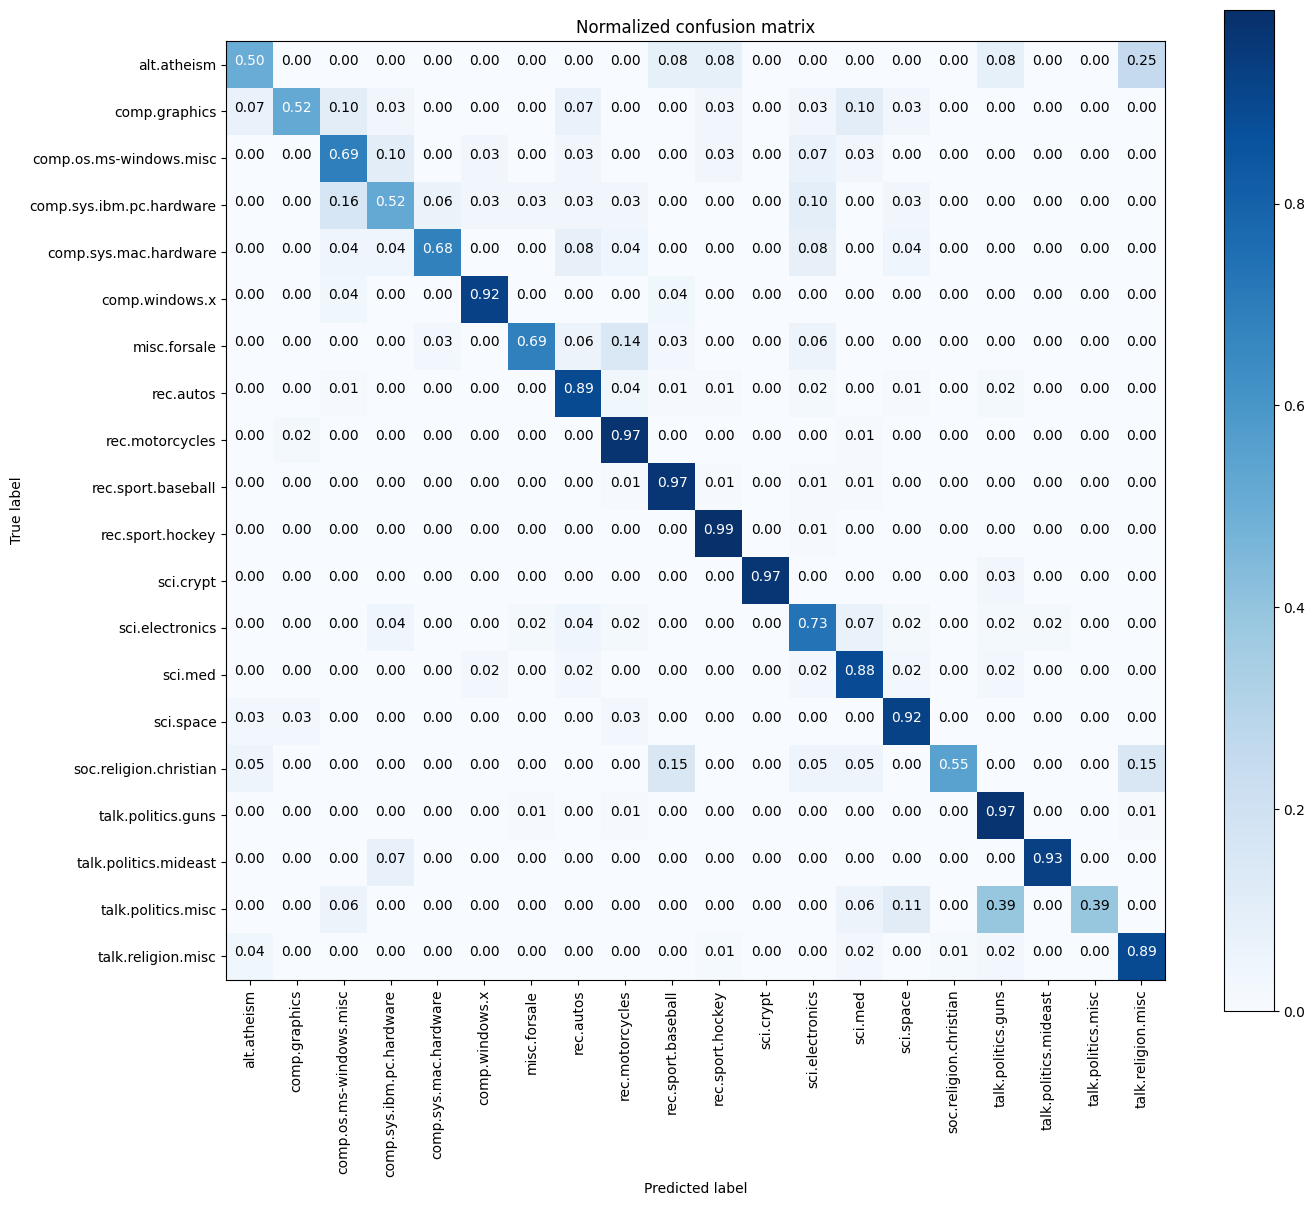

In [27]:
y_pred = model.predict(x_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)

In [28]:
prediction = model.predict(x_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [29]:
predictions = np.argmax(prediction, axis = 1)

In [30]:
predictions

array([13, 16,  8, ...,  8,  5, 16])

In [31]:
y_test_labels = np.argmax(y_test, axis =1)

In [32]:
y_test_labels

array([13, 11,  8, ...,  8,  5, 16])

In [33]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([ 9,  4, 11, ...,  9, 14, 16])

In [34]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance.
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance.
#Therefore, you will always find that the Kappa value is lower than the overall accuracy.
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy.
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.

from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test_labels, predictions)

In [35]:
cohen_score

0.8561482220334206

In [36]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test_labels, predictions)

# Loop through each element of the arrays and format them individually
for i in range(len(precision)):
    print(f'Class {i}:')
    print(f'  precision: {precision[i]:.2f}')
    print(f'  recall: {recall[i]:.2f}')
    print(f'  fscore: {fscore[i]:.2f}')
    print(f'  support: {support[i]:.2f}')

Class 0:
  precision: 0.46
  recall: 0.50
  fscore: 0.48
  support: 12.00
Class 1:
  precision: 0.83
  recall: 0.52
  fscore: 0.64
  support: 29.00
Class 2:
  precision: 0.62
  recall: 0.69
  fscore: 0.66
  support: 29.00
Class 3:
  precision: 0.67
  recall: 0.52
  fscore: 0.58
  support: 31.00
Class 4:
  precision: 0.85
  recall: 0.68
  fscore: 0.76
  support: 25.00
Class 5:
  precision: 0.89
  recall: 0.92
  fscore: 0.91
  support: 26.00
Class 6:
  precision: 0.89
  recall: 0.69
  fscore: 0.77
  support: 35.00
Class 7:
  precision: 0.90
  recall: 0.89
  fscore: 0.89
  support: 108.00
Class 8:
  precision: 0.88
  recall: 0.97
  fscore: 0.93
  support: 117.00
Class 9:
  precision: 0.94
  recall: 0.97
  fscore: 0.96
  support: 121.00
Class 10:
  precision: 0.95
  recall: 0.99
  fscore: 0.97
  support: 124.00
Class 11:
  precision: 1.00
  recall: 0.97
  fscore: 0.98
  support: 31.00
Class 12:
  precision: 0.67
  recall: 0.73
  fscore: 0.70
  support: 45.00
Class 13:
  precision: 0.75
  r

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(y_test_labels, predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall)

print(precision)

[0.5        0.51724138 0.68965517 0.51612903 0.68       0.92307692
 0.68571429 0.88888889 0.97435897 0.96694215 0.99193548 0.96774194
 0.73333333 0.88372093 0.92105263 0.55       0.97087379 0.92857143
 0.38888889 0.88888889]
[0.46153846 0.83333333 0.625      0.66666667 0.85       0.88888889
 0.88888889 0.89719626 0.88372093 0.94354839 0.95348837 1.
 0.67346939 0.74509804 0.81395349 0.91666667 0.86956522 0.92857143
 1.         0.91139241]


In [38]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class,
#based on those that already exist. It works randomly picking a point from the minority class and computing
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE(sampling_strategy='minority')

X_sm, y_sm = smote.fit_resample(x_train, y_train)
print(X_sm.shape, y_sm.shape)

(4646, 15000) (4646, 20)


In [39]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convert the class weights to a dictionary for use in model.fit
class_weight_dict = dict(enumerate(class_weights))

num_epochs = 50
batch_size = 128

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'): history = model.fit(
    X_sm,
    y_sm,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=2,
    class_weight=class_weight_dict,  # Use the dictionary here
    validation_split=0.2
)

Num GPUs Available:  1
Epoch 1/50
30/30 - 6s - 186ms/step - accuracy: 0.9755 - loss: 0.1096 - val_accuracy: 0.9075 - val_loss: 0.3803
Epoch 2/50
30/30 - 1s - 35ms/step - accuracy: 0.9825 - loss: 0.1874 - val_accuracy: 0.8989 - val_loss: 0.4714
Epoch 3/50
30/30 - 1s - 17ms/step - accuracy: 0.9876 - loss: 0.1145 - val_accuracy: 0.9065 - val_loss: 0.4683
Epoch 4/50
30/30 - 0s - 16ms/step - accuracy: 0.9935 - loss: 0.0805 - val_accuracy: 0.9065 - val_loss: 0.6353
Epoch 5/50
30/30 - 0s - 10ms/step - accuracy: 0.9965 - loss: 0.0278 - val_accuracy: 0.8957 - val_loss: 0.6242
Epoch 6/50
30/30 - 0s - 10ms/step - accuracy: 0.9981 - loss: 0.0483 - val_accuracy: 0.9140 - val_loss: 0.5778
Epoch 7/50
30/30 - 0s - 10ms/step - accuracy: 0.9987 - loss: 0.0178 - val_accuracy: 0.8989 - val_loss: 0.6758
Epoch 8/50
30/30 - 0s - 9ms/step - accuracy: 0.9995 - loss: 0.0607 - val_accuracy: 0.9054 - val_loss: 0.6929
Epoch 9/50
30/30 - 0s - 11ms/step - accuracy: 0.9989 - loss: 0.0078 - val_accuracy: 0.9194 - val_

In [40]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

9/9 - 0s - 6ms/step - accuracy: 0.8838 - loss: 0.8921
Test accuracy: 0.883809506893158


In [42]:
from sklearn.metrics import roc_curve, auc
#from scipy import interp #interp has been removed. The functionality now resides in numpy.interp
import numpy as np # numpy has interp functionality
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
    # roc_auc[i] = auc(fpr[i], tpr[i]) # changed auc computation to use numpy.interp
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) # changed auc computation to use numpy.interp

In [44]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    # Use numpy.interp instead of just interp
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

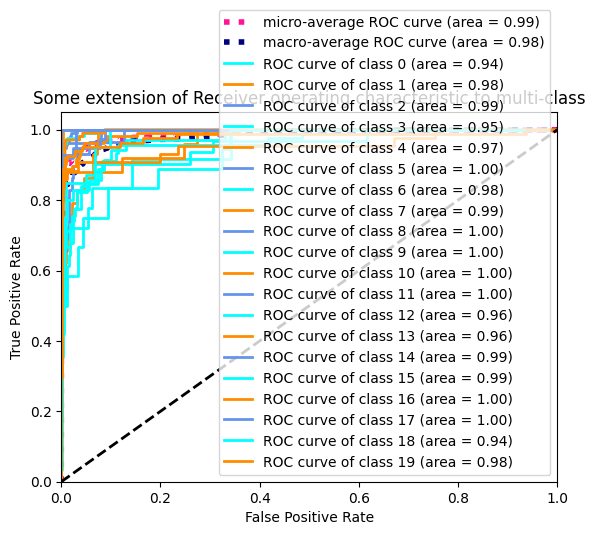

In [45]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [46]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        prediction[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], prediction[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    prediction.ravel())
average_precision["micro"] = average_precision_score(y_test, prediction,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.93


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.93')

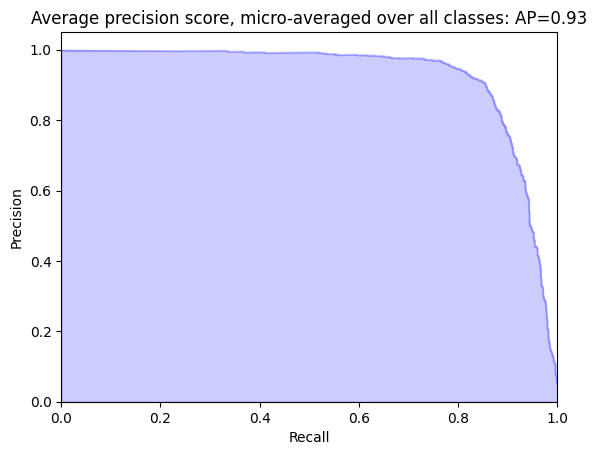

In [47]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

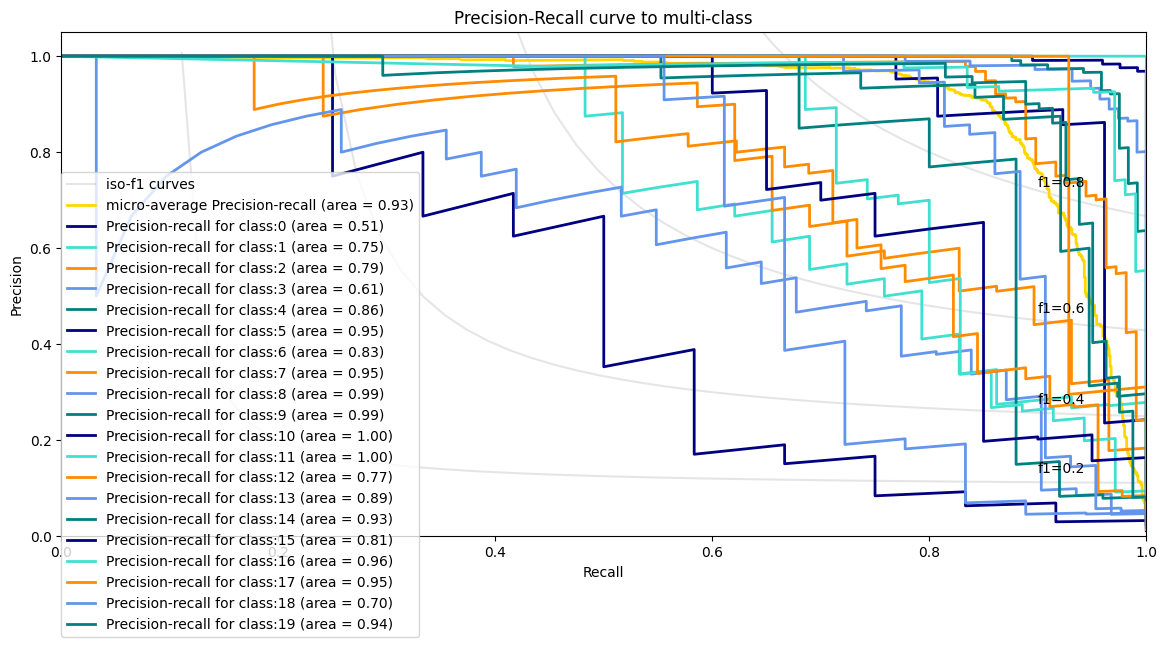

In [48]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()